# import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# data download and load

choose "simple_demo" or "whole" mod.
"simple_demo": Runs directly on colab.

"whole": Download the full data from Baidu driver and upload to colab.

In [ ]:
"""
simple_demo:
  NTU-RGB-D 10, cls=10, frames=80, use to colab simple test
  >>> (200, 3, 80, 25)
  >>> (2000, 3, 80, 25)
  >>> (200,)
  >>> (2000,)
  NTU-RGB-D 60, cls=60, frames=200, use to colab whole test

whole:
  >>> (16487, 3, 300, 25)
  >>> (40091, 3, 300, 25)
  >>> (16487,)
  >>> (40091,)
"""

mod = "simple_demo" # "simple_demo" or "whole"

if mod == "simple_demo":
  if not os.path.exists("data"):
    if not os.path.exists("data.zip"):
      !wget -q http://mprg.cs.chubu.ac.jp/~itaya/share/mprg_colab/NTU-RGBD_data/data.zip
    !unzip -q -o data.zip
elif mod == "whole":
  assert os.path.exists("data/test_data.npy"), "Download from: https://pan.baidu.com/s/1LqjL-5YljLN3kajoXpUcmQ?pwd=stgc code: stgc"
  assert os.path.exists("data/train_data.npy"), "Download from: https://pan.baidu.com/s/1LqjL-5YljLN3kajoXpUcmQ?pwd=stgc code: stgc "
  assert os.path.exists("data/test_label.npy"), "Download from: https://pan.baidu.com/s/1LqjL-5YljLN3kajoXpUcmQ?pwd=stgc code: stgc"
  assert os.path.exists("data/train_label.npy"), "Download from: https://pan.baidu.com/s/1LqjL-5YljLN3kajoXpUcmQ?pwd=stgc code: stgc"
test_data = np.load("data/test_data.npy")
train_data = np.load("data/train_data.npy")
test_label = np.load("data/test_label.npy")
train_label = np.load("data/train_label.npy")

In [ ]:
class Feeder(torch.utils.data.Dataset):
  def __init__(self, data_path, label_path):
      super().__init__()
      self.label = np.load(label_path)
      self.data = np.load(data_path)

  def __len__(self):
      return len(self.label)

  def __iter__(self):
      return self

  def __getitem__(self, index):
      data = np.array(self.data[index])
      label = self.label[index]
      return data, label

# graph structure

In [ ]:
class Graph():
  def __init__(self, hop_size):
    self.get_edge()
    self.hop_size = hop_size
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)
    self.get_adjacency()

  def __str__(self):
    return self.A

  def get_edge(self):
    self.num_node = 25
    self_link = [(i, i) for i in range(self.num_node)] # Loop
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
    self.edge = self_link + neighbor_link

  def get_adjacency(self):
    valid_hop = range(0, self.hop_size + 1, 1)
    adjacency = np.zeros((self.num_node, self.num_node))
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1
    normalize_adjacency = self.normalize_digraph(adjacency)
    A = np.zeros((len(valid_hop), self.num_node, self.num_node))
    for i, hop in enumerate(valid_hop):
        A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
    self.A = A

  def get_hop_distance(self, num_node, edge, hop_size):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

class Sparse_Graph():
    def __init__(self, hop_size):
        self.get_edge()
        self.hop_size = hop_size
        self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)
        self.get_adjacency()

    def __str__(self):
        return str(self.A)

    def get_edge(self):
        self.num_node = 25
        self_link = [(i, i) for i in range(self.num_node)] # Loop
        neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                          (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                          (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                          (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                          (22, 23), (23, 8), (24, 25), (25, 12)]
        neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
        self.edge = self_link + neighbor_link

    def get_adjacency(self):
        valid_hop = range(0, self.hop_size + 1, 1)
        adjacency = sp.lil_matrix((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = self.normalize_digraph(adjacency)
        A = np.zeros((len(valid_hop), self.num_node, self.num_node))
        for i, hop in enumerate(valid_hop):
            A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
        self.A = A

    def get_hop_distance(self, num_node, edge, hop_size):
        A = sp.lil_matrix((num_node, num_node))
        for i, j in edge:
            A[j, i] = 1
            A[i, j] = 1
        hop_dis = np.zeros((num_node, num_node)) + np.inf
        transfer_mat = [np.linalg.matrix_power(A.toarray(), d) for d in range(hop_size + 1)]
        arrive_mat = (np.stack(transfer_mat) > 0)
        for d in range(hop_size, -1, -1):
            hop_dis[arrive_mat[d]] = d
        return hop_dis

    def normalize_digraph(self, A):
        Dl = np.sum(A, 0)
        num_node = A.shape[0]
        Dn = np.zeros((num_node, num_node))
        for i in range(num_node):
            if Dl[i] > 0:
                Dn[i, i] = Dl[i]**(-1)
        DAD = np.dot(A.toarray(), Dn)
        return DAD

# SGC, SSGC, SGCPP, TGCPP

In [ ]:
class SpatialGraphConvolution(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super().__init__()
    self.s_kernel_size = s_kernel_size
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels * s_kernel_size,
                          kernel_size=1)

  def forward(self, x, A):
    x = self.conv(x)
    n, kc, t, v = x.size()
    x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    x = torch.einsum('nkctv,kvw->nctw', (x, A))
    return x.contiguous()

class SpatialSeparateGraphConvolution(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super().__init__()
    self.s_kernel_size = s_kernel_size
    self.deep_wise_conv = nn.Conv2d(in_channels=in_channels,
                out_channels=in_channels,
                kernel_size=3,
                padding=1,
                groups=in_channels,
                )
    self.point_wise_conv = nn.Conv2d(in_channels=in_channels,
                    out_channels=out_channels * s_kernel_size, kernel_size=1)


  def forward(self, x, A):
    x = self.deep_wise_conv(x)
    x = self.point_wise_conv(x)
    n, kc, t, v = x.size()
    x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    x = torch.einsum('nkctv,kvw->nctw', (x, A))
    return x.contiguous()

SGCPP, TGCPP in [ST-GCN++](https://arxiv.org/pdf/2205.09443)

In [ ]:
class SpatialGraphConvolutionPlusPlus(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super().__init__()
    self.s_kernel_size = s_kernel_size
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels * s_kernel_size,
                          kernel_size=1)

  def forward(self, x, A):
    # print("SGC_0: ", x.shape)
    y = self.conv(x)
    n, kc, t, v = y.size()
    y = y.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    y = torch.einsum('nkctv,kvw->nctw', (y, A))
    if y.shape == x.shape:
        y += x
    # print("SGC_1: ", x.shape)
    # print("SGC_2: ", x.contiguous().shape)
    return y.contiguous()

class TemporalGraphConvolutionPlusPlus(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.cv1_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv2_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv3_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv4_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv5_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv6_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)

        self.cv2_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(3,1), stride=1, dilation=1, padding=(1,0))
        self.cv3_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(3,1), stride=1, dilation=2, padding=(2,0))
        self.cv4_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(3,1), stride=1, dilation=3, padding=(3,0))
        self.cv5_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(3,1), stride=1, dilation=4, padding=(4,0))
        self.cv6_2 = nn.MaxPool2d(kernel_size=(3,1),stride=(1,1),padding=(1,0))

        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.cv1_1(x)
        x2 = self.cv2_2(self.cv2_1(x))
        x3 = self.cv3_2(self.cv3_1(x))
        x4 = self.cv4_2(self.cv4_1(x))
        x5 = self.cv5_2(self.cv5_1(x))
        x6 = self.cv6_2(self.cv6_1(x))
        y = x1+x2+x3+x4+x5+x6
        y = self.relu(self.bn(y))
        return y

SSGC+SGCPP=SSGCPP, TDGC+TGCPP=TDGCPP

In [ ]:
class SpatialSeparateGraphConvolutionPlusPlus(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super().__init__()
    self.s_kernel_size = s_kernel_size
    self.deep_wise_conv = nn.Conv2d(in_channels=in_channels,
                out_channels=in_channels,
                kernel_size=3,
                padding=1,
                groups=in_channels,
                )
    self.point_wise_conv = nn.Conv2d(in_channels=in_channels,
                    out_channels=out_channels * s_kernel_size, kernel_size=1)


  def forward(self, x, A):
    y = self.deep_wise_conv(x)
    y = self.point_wise_conv(y)
    n, kc, t, v = y.size()
    y = y.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    y = torch.einsum('nkctv,kvw->nctw', (y, A))
    if y.shape == x.shape:
        y+=x
    return y.contiguous()

class TemporalDilationGraphConvolutionPlusPlus(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.cv1_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv2_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv3_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv4_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv5_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)
        self.cv6_1 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(1,1), stride=1)

        self.cv2_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(3,1), stride=1, dilation=1, padding=(1,0))
        self.cv3_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(3,1), stride=1, dilation=2, padding=(2,0))
        self.cv4_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(3,1), stride=1, dilation=3, padding=(3,0))
        self.cv5_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=(3,1), stride=1, dilation=4, padding=(4,0))
        self.cv6_2 = nn.MaxPool2d(kernel_size=(3,1),stride=(1,1),padding=(1,0))

        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.cv1_1(x)
        x2 = self.cv2_2(self.cv2_1(x))
        x3 = self.cv3_2(self.cv3_1(x))
        x4 = self.cv4_2(self.cv4_1(x))
        x5 = self.cv5_2(self.cv5_1(x))
        x6 = self.cv6_2(self.cv6_1(x))
        y = x1+x2+x3+x4+x5+x6
        y = self.relu(self.bn(y))
        return y

# STGC, SSTGC, STDGC, SSTDGC, STGCL, STGCPP, SSTDGCPP blocks

In [ ]:
class STGC_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    self.sgc = SpatialGraphConvolution(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])

    self.M = nn.Parameter(torch.ones(A_size))

    self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Conv2d(out_channels,
                                      out_channels,
                                      (t_kernel_size, 1), # kernel_size
                                      (stride, 1), # stride
                                      ((t_kernel_size - 1) // 2, 0), # padding
                                      ),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())

  def forward(self, x, A):
    x = self.tgc(self.sgc(x, A * self.M))
    return x


class SSTGC_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    self.sgc = SpatialSeparateGraphConvolution(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])

    self.M = nn.Parameter(torch.ones(A_size))

    self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Conv2d(out_channels,
                                      out_channels,
                                      (t_kernel_size, 1), # kernel_size
                                      (stride, 1), # stride
                                      ((t_kernel_size - 1) // 2, 0), # padding
                                      ),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())

  def forward(self, x, A):
    x = self.tgc(self.sgc(x, A * self.M))
    return x


class STDGC_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    self.sgc = SpatialGraphConvolution(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])

    self.M = nn.Parameter(torch.ones(A_size))

    self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Conv2d(out_channels,
                                      out_channels,
                                      (t_kernel_size, 1), # kernel_size
                                      (stride, 1), # stride
                                      ((t_kernel_size - 1) // 2, 0), # padding
                                      dilation = 2,
                                      ),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())

  def forward(self, x, A):
    x = self.tgc(self.sgc(x, A * self.M))
    return x


class SSTDGC_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    self.sgc = SpatialSeparateGraphConvolution(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])

    self.M = nn.Parameter(torch.ones(A_size))

    self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Conv2d(out_channels,
                                      out_channels,
                                      (t_kernel_size, 1), # kernel_size
                                      (stride, 1), # stride
                                      ((t_kernel_size - 1) // 2, 0), # padding
                                      dilation = 2,
                                      ),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())

  def forward(self, x, A):
    x = self.tgc(self.sgc(x, A * self.M))
    return x

STGCL block

In [ ]:
class STGCL_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    self.sgc = SpatialGraphConvolution(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])

    self.M = nn.Parameter(torch.ones(A_size)) # 论文中的A
    self.K = nn.Parameter(torch.ones(A_size)) # 论文中的K

    self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Conv2d(out_channels,
                                      out_channels,
                                      (t_kernel_size, 1), # kernel_size
                                      (stride, 1), # stride
                                      ((t_kernel_size - 1) // 2, 0), # padding
                                      ),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())

  def forward(self, x, A):
    x = self.tgc(self.sgc(x, torch.mul(A,self.M) + self.K))
    return x

STGC++ block

In [ ]:
class STGCPP_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    self.sgcpp = SpatialGraphConvolutionPlusPlus(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])

    self.M = nn.Parameter(torch.ones(A_size))

    """
    Cite from https://arxiv.org/pdf/2205.09443 :
    "We use a multi-branch temporal ConvNet (TCN) to replace the single branch design.
    The adopted multi-branch TCN consists of six branches: a ‘1x1’ Conv branch, a Max-Pooling branch,
    and four temporal 1D Conv branches with kernel size 3 and dilations from 1 to 4. It first transforms features
    with ‘1x1’ Conv and divides them into six groups with equal channel width.
    Then, each feature group is processed with a single branch. The six outputs are concatenated together
    and processed by another ‘1x1’ Conv to form the output of the multi-branch TCN.
    The new TCN design not only improves the temporal modeling capabililty,
    but also saves the computational cost and parameters, due to the reduced channel width for every single branch."
    """
    self.tgcpp =  TemporalGraphConvolutionPlusPlus(out_channels)

  def forward(self, x, A):
    x = self.tgcpp(self.sgcpp(x, A * self.M))
    return x

SSTDGC++ block

In [ ]:
class SSTDGCPP_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    self.ssgcpp = SpatialSeparateGraphConvolutionPlusPlus(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])

    self.M = nn.Parameter(torch.ones(A_size))
    self.tdgcpp = TemporalDilationGraphConvolutionPlusPlus(out_channels)

  def forward(self, x, A):
    x = self.tdgcpp(self.ssgcpp(x, A * self.M))
    return x

# models

ST_GCN, SST_GCN, STD_GCN, SSTD_GCN (ours model)

In [ ]:
class ST_GCN(nn.Module):
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    # graph制作
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1]) # 75

    # STGC_blocks
    self.stgc1 = STGC_block(in_channels, 32, 1, t_kernel_size, A_size) # in_c=3, t_k_s= 9， 1是步长
    self.stgc2 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = STGC_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = STGC_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = STGC_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node

    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x


class SST_GCN(nn.Module):
  # Spacial Separate Temporal GCN
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1]) # 75

    # STGC_blocks
    self.stgc1 = SSTGC_block(in_channels, 32, 1, t_kernel_size, A_size) # in_c=3, t_k_s= 9， 1是步长
    self.stgc2 = SSTGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = SSTGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = SSTGC_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = SSTGC_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = SSTGC_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node

    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x


class STD_GCN(nn.Module):
  # Spacial Temporal Dilation GCN
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1]) # 75

    # STGC_blocks
    self.stgc1 = STDGC_block(in_channels, 32, 1, t_kernel_size, A_size) # in_c=3, t_k_s= 9， 1是步长
    self.stgc2 = STDGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = STDGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = STDGC_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = STDGC_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = STDGC_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node

    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x


class SSTD_GCN(nn.Module):
  # Spacial Temporal Dilation GCN
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    # graph制作
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1]) # 75

    # STGC_blocks
    self.stgc1 = SSTDGC_block(in_channels, 32, 1, t_kernel_size, A_size) # in_c=3, t_k_s= 9， 1是步长
    self.stgc2 = SSTDGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = SSTDGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = SSTDGC_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = SSTDGC_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = SSTDGC_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node

    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x

STGL_GCN(others, 2023)

In [ ]:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10047922
class STGL_GCN(nn.Module):
  # Spacial Temporal Dilation GCN
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    # graph制作
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    # D = torch.tensor(torch.randn_like(graph.A), dtype=torch.float32, requires_grad=False)
    # E = torch.tensor(torch.randn_like(graph.A), dtype=torch.float32, requires_grad=False)

    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1]) # 75

    # STGC_blocks
    self.stgc1 = STGCL_block(in_channels, 64, 1, t_kernel_size, A_size) # in_c=3, t_k_s= 9， 1是步长
    self.stgc2 = STGCL_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc3 = STGCL_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc4 = STGCL_block(64, 128, 2, t_kernel_size, A_size)
    self.stgc5 = STGCL_block(128, 128, 1, t_kernel_size, A_size)
    self.stgc6 = STGCL_block(128, 128, 1, t_kernel_size, A_size)
    self.stgc7 = STGCL_block(128, 256, 2, t_kernel_size, A_size)
    self.stgc8 = STGCL_block(256, 256, 1, t_kernel_size, A_size)
    self.stgc9 = STGCL_block(256, 256, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(256, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node

    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)
    x = self.stgc7(x, self.A)
    x = self.stgc8(x, self.A)
    x = self.stgc9(x, self.A)


    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x

STGCN++(others, 2022)

In [ ]:
# https://arxiv.org/pdf/2205.09443
class ST_GCNPP(nn.Module):
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    # graph制作
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1]) # 75

    # STGC_blocks
    # 需要把STGC模块中的sgc添加残差链接，tgc添加类似Inception模块
    self.stgc1 = STGCPP_block(in_channels, 32, 1, t_kernel_size, A_size) # in_c=3, t_k_s= 9， 1是步长
    self.stgc2 = STGCPP_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = STGCPP_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = STGCPP_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = STGCPP_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = STGCPP_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node

    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x

SSTD-GCN++: STGCN++ with SSTDGCN (Ours is embedded in theirs)

In [ ]:
class SSTD_GCNPP(nn.Module):
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    # graph制作
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1]) # 75

    # STGC_blocks
    self.stgc1 = SSTDGCPP_block(in_channels, 32, 1, t_kernel_size, A_size) # in_c=3, t_k_s= 9， 1是步长
    self.stgc2 = SSTDGCPP_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = SSTDGCPP_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = SSTDGCPP_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = SSTDGCPP_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = SSTDGCPP_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node

    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x

# model Params and FLOPs

In [ ]:
!pip install thop
from thop import profile
from contextlib import redirect_stdout

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:

model_list = ["ST_GCN", "SST_GCN", "STD_GCN", "SSTD_GCN", "STGL_GCN", "ST_GCNPP", "SSTD_GCNPP"]

def choose_model(model_name):
  model_class = eval(model_name)
  model = model_class(num_classes=10, in_channels=3, t_kernel_size=9, hop_size=1)
  total_params = sum(p.numel() for p in model.parameters())
  with redirect_stdout(None):
    total_flops, _ = profile(model_class(num_classes=10, in_channels=3, t_kernel_size=9, hop_size=1), inputs=(torch.randn(1,3,80,25),))
  print(f"{model_name:10}模型Params: {total_params:10} = {total_params/1e6:6.2f}M, Mem: {total_params * 4 / (1024 ** 2):6.2f}MB, 浮点运算: {total_flops:10.0f}FLOPs = {total_flops/1e9:5.2f}GFLOPs")

for model_name in model_list:
  choose_model(model_name)

ST_GCN    模型Params:     173324 =   0.17M, Mem:   0.66MB, 浮点运算:  202392640FLOPs =  0.20GFLOPs
SST_GCN   模型Params:     175594 =   0.18M, Mem:   0.67MB, 浮点运算:  205326640FLOPs =  0.21GFLOPs
STD_GCN   模型Params:     173324 =   0.17M, Mem:   0.66MB, 浮点运算:  111999040FLOPs =  0.11GFLOPs
SSTD_GCN  模型Params:     175594 =   0.18M, Mem:   0.67MB, 浮点运算:  114011440FLOPs =  0.11GFLOPs
STGL_GCN  模型Params:    2783428 =   2.78M, Mem:  10.62MB, 浮点运算: 1887002560FLOPs =  1.89GFLOPs
ST_GCNPP  模型Params:     313580 =   0.31M, Mem:   1.20MB, 浮点运算:  604824640FLOPs =  0.60GFLOPs
SSTD_GCNPP模型Params:     315850 =   0.32M, Mem:   1.20MB, 浮点运算:  608910640FLOPs =  0.61GFLOPs


# Train

## ST-GCN(Top1 Acc=76)

In [ ]:
# ST-GCN
NUM_EPOCH = 200
BATCH_SIZE = 256
acc_list = []
val_acc_list = []
best_acc = 0
val_best_acc = 0
model = ST_GCN(num_classes=10,
                  in_channels=3,
                  t_kernel_size=9,
                  hop_size=1).cuda()


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)


for epoch in range(1, NUM_EPOCH+1):
  model.train()
  correct = 0
  sum_loss = 0
  val_correct = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()
    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()
  acc = (100. * correct / len(data_loader['train'].dataset))
  acc_list.append(acc)
  if acc > best_acc:
    best_acc = acc
  print('# Train: Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), acc, best_acc))
  with torch.no_grad():
    model.eval()
    for batch_idx, (data, label) in enumerate(data_loader['test']):
      data = data.cuda()
      label = label.cuda()
      output = model(data)

      _, predict = torch.max(output.data, 1)
      val_correct += (predict == label).sum().item()
  val_acc = (100. * val_correct / len(data_loader['test'].dataset))
  val_acc_list.append(val_acc)
  if val_acc > val_best_acc:
    val_best_acc = val_acc
  print('# val : Epoch: {} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, val_acc, val_best_acc))

# Train: Epoch: 1 | Loss: 0.0092 | Accuracy: 9.7500 | best acc: 9.7500
# val : Epoch: 1 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 2 | Loss: 0.0092 | Accuracy: 12.7500 | best acc: 12.7500
# val : Epoch: 2 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 3 | Loss: 0.0091 | Accuracy: 16.6000 | best acc: 16.6000
# val : Epoch: 3 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 4 | Loss: 0.0089 | Accuracy: 17.9500 | best acc: 17.9500
# val : Epoch: 4 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 5 | Loss: 0.0088 | Accuracy: 20.0000 | best acc: 20.0000
# val : Epoch: 5 | Accuracy: 12.5000 | best acc: 12.5000
# Train: Epoch: 6 | Loss: 0.0087 | Accuracy: 20.8000 | best acc: 20.8000
# val : Epoch: 6 | Accuracy: 13.0000 | best acc: 13.0000
# Train: Epoch: 7 | Loss: 0.0086 | Accuracy: 20.9000 | best acc: 20.9000
# val : Epoch: 7 | Accuracy: 15.0000 | best acc: 15.0000
# Train: Epoch: 8 | Loss: 0.0085 | Accuracy: 22.1500 | best acc: 22.1500
# val : Epoch: 8 | 

## SST-GCN(Top1 Acc=81.5)

In [ ]:
# SST-GCN
NUM_EPOCH = 200
BATCH_SIZE = 256
acc_list1 = []
val_acc_list1 = []
best_acc = 0
val_best_acc = 0
model = SST_GCN(num_classes=10,
                  in_channels=3,
                  t_kernel_size=9,
                  hop_size=1).cuda()


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)


for epoch in range(1, NUM_EPOCH+1):
  model.train()
  correct = 0
  sum_loss = 0
  val_correct = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()
    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()
  acc = (100. * correct / len(data_loader['train'].dataset))
  acc_list1.append(acc)
  if acc > best_acc:
    best_acc = acc
  print('# Train: Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), acc, best_acc))
  with torch.no_grad():
    model.eval()
    for batch_idx, (data, label) in enumerate(data_loader['test']):
      data = data.cuda()
      label = label.cuda()
      output = model(data)

      _, predict = torch.max(output.data, 1)
      val_correct += (predict == label).sum().item()
  val_acc = (100. * val_correct / len(data_loader['test'].dataset))
  val_acc_list1.append(val_acc)
  if val_acc > val_best_acc:
    val_best_acc = val_acc
  print('# val : Epoch: {} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, val_acc, val_best_acc))

# Train: Epoch: 1 | Loss: 0.0092 | Accuracy: 9.8500 | best acc: 9.8500
# val : Epoch: 1 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 2 | Loss: 0.0092 | Accuracy: 14.5000 | best acc: 14.5000
# val : Epoch: 2 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 3 | Loss: 0.0090 | Accuracy: 17.3000 | best acc: 17.3000
# val : Epoch: 3 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 4 | Loss: 0.0089 | Accuracy: 17.2500 | best acc: 17.3000
# val : Epoch: 4 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 5 | Loss: 0.0088 | Accuracy: 16.8000 | best acc: 17.3000
# val : Epoch: 5 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 6 | Loss: 0.0088 | Accuracy: 15.1500 | best acc: 17.3000
# val : Epoch: 6 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 7 | Loss: 0.0087 | Accuracy: 14.7000 | best acc: 17.3000
# val : Epoch: 7 | Accuracy: 12.5000 | best acc: 12.5000
# Train: Epoch: 8 | Loss: 0.0086 | Accuracy: 19.0500 | best acc: 19.0500
# val : Epoch: 8 | 

## STD-GCN(Top1 Acc=78.5)

In [ ]:
# STD-GCN
NUM_EPOCH = 200
BATCH_SIZE = 256
acc_list2 = []
val_acc_list2 = []
best_acc = 0
val_best_acc = 0
model = STD_GCN(num_classes=10,
                  in_channels=3,
                  t_kernel_size=9,
                  hop_size=1).cuda()


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)


for epoch in range(1, NUM_EPOCH+1):
  model.train()
  correct = 0
  sum_loss = 0
  val_correct = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()
    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()
  acc = (100. * correct / len(data_loader['train'].dataset))
  acc_list2.append(acc)
  if acc > best_acc:
    best_acc = acc
  print('# Train: Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), acc, best_acc))
  with torch.no_grad():
    model.eval()
    for batch_idx, (data, label) in enumerate(data_loader['test']):
      data = data.cuda()
      label = label.cuda()
      output = model(data)

      _, predict = torch.max(output.data, 1)
      val_correct += (predict == label).sum().item()
  val_acc = (100. * val_correct / len(data_loader['test'].dataset))
  val_acc_list2.append(val_acc)
  if val_acc > val_best_acc:
    val_best_acc = val_acc
  print('# val : Epoch: {} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, val_acc, val_best_acc))

# Train: Epoch: 1 | Loss: 0.0093 | Accuracy: 12.1000 | best acc: 12.1000
# val : Epoch: 1 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 2 | Loss: 0.0091 | Accuracy: 15.7500 | best acc: 15.7500
# val : Epoch: 2 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 3 | Loss: 0.0089 | Accuracy: 16.2000 | best acc: 16.2000
# val : Epoch: 3 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 4 | Loss: 0.0087 | Accuracy: 20.3500 | best acc: 20.3500
# val : Epoch: 4 | Accuracy: 12.5000 | best acc: 12.5000
# Train: Epoch: 5 | Loss: 0.0086 | Accuracy: 18.5000 | best acc: 20.3500
# val : Epoch: 5 | Accuracy: 15.0000 | best acc: 15.0000
# Train: Epoch: 6 | Loss: 0.0085 | Accuracy: 20.8500 | best acc: 20.8500
# val : Epoch: 6 | Accuracy: 16.5000 | best acc: 16.5000
# Train: Epoch: 7 | Loss: 0.0084 | Accuracy: 24.5000 | best acc: 24.5000
# val : Epoch: 7 | Accuracy: 17.5000 | best acc: 17.5000
# Train: Epoch: 8 | Loss: 0.0083 | Accuracy: 25.8500 | best acc: 25.8500
# val : Epoch: 8 

## SSTD-GCN（ours final model, Top1 Acc=87）

In [ ]:
# SSTD-GCN
NUM_EPOCH = 200
BATCH_SIZE = 256
acc_list3 = []
val_acc_list3 = []
best_acc = 0
val_best_acc = 0
model = SSTD_GCN(num_classes=10,
                  in_channels=3,
                  t_kernel_size=9,
                  hop_size=1).cuda()


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)


for epoch in range(1, NUM_EPOCH+1):
  model.train()
  correct = 0
  sum_loss = 0
  val_correct = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()
    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()
  acc = (100. * correct / len(data_loader['train'].dataset))
  acc_list3.append(acc)
  if acc > best_acc:
    best_acc = acc
  print('# Train: Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), acc, best_acc))
  with torch.no_grad():
    model.eval()
    for batch_idx, (data, label) in enumerate(data_loader['test']):
      data = data.cuda()
      label = label.cuda()
      output = model(data)

      _, predict = torch.max(output.data, 1)
      val_correct += (predict == label).sum().item()
  val_acc = (100. * val_correct / len(data_loader['test'].dataset))
  val_acc_list3.append(val_acc)
  if val_acc > val_best_acc:
    val_best_acc = val_acc
  print('# val : Epoch: {} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, val_acc, val_best_acc))

# Train: Epoch: 1 | Loss: 0.0093 | Accuracy: 10.0000 | best acc: 10.0000
# val : Epoch: 1 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 2 | Loss: 0.0091 | Accuracy: 12.5000 | best acc: 12.5000
# val : Epoch: 2 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 3 | Loss: 0.0089 | Accuracy: 18.8000 | best acc: 18.8000
# val : Epoch: 3 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 4 | Loss: 0.0087 | Accuracy: 21.3000 | best acc: 21.3000
# val : Epoch: 4 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 5 | Loss: 0.0086 | Accuracy: 20.7500 | best acc: 21.3000
# val : Epoch: 5 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 6 | Loss: 0.0084 | Accuracy: 22.4500 | best acc: 22.4500
# val : Epoch: 6 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 7 | Loss: 0.0083 | Accuracy: 23.6500 | best acc: 23.6500
# val : Epoch: 7 | Accuracy: 10.0000 | best acc: 10.0000
# Train: Epoch: 8 | Loss: 0.0082 | Accuracy: 24.9000 | best acc: 24.9000
# val : Epoch: 8 

## STGL-GCN(Top1 Acc=77.5)

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10047922


In [ ]:
# STGL-GCN
NUM_EPOCH = 200
BATCH_SIZE = 16
acc_list4 = []
val_acc_list4 = []
best_acc = 0
val_best_acc = 0
model = STGL_GCN(num_classes=10,
                  in_channels=3,
                  t_kernel_size=9,
                  hop_size=1).cuda()


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)


for epoch in range(1, NUM_EPOCH+1):
  model.train()
  correct = 0
  sum_loss = 0
  val_correct = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()
    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()
  acc = (100. * correct / len(data_loader['train'].dataset))
  acc_list4.append(acc)
  if acc > best_acc:
    best_acc = acc
  print('# Train: Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), acc, best_acc))
  with torch.no_grad():
    model.eval()
    for batch_idx, (data, label) in enumerate(data_loader['test']):
      data = data.cuda()
      label = label.cuda()
      output = model(data)

      _, predict = torch.max(output.data, 1)
      val_correct += (predict == label).sum().item()
  val_acc = (100. * val_correct / len(data_loader['test'].dataset))
  val_acc_list4.append(val_acc)
  if val_acc > val_best_acc:
    val_best_acc = val_acc
  print('# val : Epoch: {} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, val_acc, val_best_acc))

# Train: Epoch: 1 | Loss: 0.1323 | Accuracy: 22.7500 | best acc: 22.7500
# val : Epoch: 1 | Accuracy: 25.0000 | best acc: 25.0000
# Train: Epoch: 2 | Loss: 0.1155 | Accuracy: 32.1000 | best acc: 32.1000
# val : Epoch: 2 | Accuracy: 39.0000 | best acc: 39.0000
# Train: Epoch: 3 | Loss: 0.0915 | Accuracy: 46.7000 | best acc: 46.7000
# val : Epoch: 3 | Accuracy: 43.0000 | best acc: 43.0000
# Train: Epoch: 4 | Loss: 0.0777 | Accuracy: 54.9500 | best acc: 54.9500
# val : Epoch: 4 | Accuracy: 54.5000 | best acc: 54.5000
# Train: Epoch: 5 | Loss: 0.0713 | Accuracy: 57.7000 | best acc: 57.7000
# val : Epoch: 5 | Accuracy: 50.5000 | best acc: 54.5000
# Train: Epoch: 6 | Loss: 0.0666 | Accuracy: 61.9000 | best acc: 61.9000
# val : Epoch: 6 | Accuracy: 55.5000 | best acc: 55.5000
# Train: Epoch: 7 | Loss: 0.0633 | Accuracy: 62.5500 | best acc: 62.5500
# val : Epoch: 7 | Accuracy: 63.5000 | best acc: 63.5000
# Train: Epoch: 8 | Loss: 0.0602 | Accuracy: 65.0500 | best acc: 65.0500
# val : Epoch: 8 

## ST-GCN++(Top1 Acc=90.5)

In [ ]:
NUM_EPOCH = 200
BATCH_SIZE = 32
acc_list5 = []
val_acc_list5 = []
best_acc = 0
val_best_acc = 0
model = ST_GCNPP(num_classes=10,
                  in_channels=3,
                  t_kernel_size=9,
                  hop_size=1).cuda()


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)


for epoch in range(1, NUM_EPOCH+1):
  model.train()
  correct = 0
  sum_loss = 0
  val_correct = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()
    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()
  acc = (100. * correct / len(data_loader['train'].dataset))
  acc_list5.append(acc)
  if acc > best_acc:
    best_acc = acc
  print('# Train: Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), acc, best_acc))
  with torch.no_grad():
    model.eval()
    for batch_idx, (data, label) in enumerate(data_loader['test']):
      data = data.cuda()
      label = label.cuda()
      output = model(data)

      _, predict = torch.max(output.data, 1)
      val_correct += (predict == label).sum().item()
  val_acc = (100. * val_correct / len(data_loader['test'].dataset))
  val_acc_list5.append(val_acc)
  if val_acc > val_best_acc:
    val_best_acc = val_acc
  print('# val : Epoch: {} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, val_acc, val_best_acc))

# Train: Epoch: 1 | Loss: 0.0677 | Accuracy: 21.3500 | best acc: 21.3500
# val : Epoch: 1 | Accuracy: 24.5000 | best acc: 24.5000
# Train: Epoch: 2 | Loss: 0.0627 | Accuracy: 28.4500 | best acc: 28.4500
# val : Epoch: 2 | Accuracy: 28.0000 | best acc: 28.0000
# Train: Epoch: 3 | Loss: 0.0601 | Accuracy: 32.6500 | best acc: 32.6500
# val : Epoch: 3 | Accuracy: 30.5000 | best acc: 30.5000
# Train: Epoch: 4 | Loss: 0.0561 | Accuracy: 37.6500 | best acc: 37.6500
# val : Epoch: 4 | Accuracy: 39.0000 | best acc: 39.0000
# Train: Epoch: 5 | Loss: 0.0494 | Accuracy: 47.7500 | best acc: 47.7500
# val : Epoch: 5 | Accuracy: 46.5000 | best acc: 46.5000
# Train: Epoch: 6 | Loss: 0.0429 | Accuracy: 55.1000 | best acc: 55.1000
# val : Epoch: 6 | Accuracy: 52.5000 | best acc: 52.5000
# Train: Epoch: 7 | Loss: 0.0380 | Accuracy: 59.0000 | best acc: 59.0000
# val : Epoch: 7 | Accuracy: 62.0000 | best acc: 62.0000
# Train: Epoch: 8 | Loss: 0.0355 | Accuracy: 62.6000 | best acc: 62.6000
# val : Epoch: 8 

## SSTD-GCN++(Top1 Acc=92)

In [ ]:
NUM_EPOCH = 200
BATCH_SIZE = 32
acc_list6 = []
val_acc_list6 = []
best_acc = 0
val_best_acc = 0
model = SSTD_GCNPP(num_classes=10,
                  in_channels=3,
                  t_kernel_size=9,
                  hop_size=1).cuda()


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)


for epoch in range(1, NUM_EPOCH+1):
  model.train()
  correct = 0
  sum_loss = 0
  val_correct = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()
    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()
  acc = (100. * correct / len(data_loader['train'].dataset))
  acc_list6.append(acc)
  if acc > best_acc:
    best_acc = acc
  print('# Train: Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), acc, best_acc))
  with torch.no_grad():
    model.eval()
    for batch_idx, (data, label) in enumerate(data_loader['test']):
      data = data.cuda()
      label = label.cuda()
      output = model(data)

      _, predict = torch.max(output.data, 1)
      val_correct += (predict == label).sum().item()
  val_acc = (100. * val_correct / len(data_loader['test'].dataset))
  val_acc_list6.append(val_acc)
  if val_acc > val_best_acc:
    val_best_acc = val_acc
  print('# val : Epoch: {} | Accuracy: {:.4f} | best acc: {:.4f}'.format(epoch, val_acc, val_best_acc))

# Train: Epoch: 1 | Loss: 0.0684 | Accuracy: 20.3000 | best acc: 20.3000
# val : Epoch: 1 | Accuracy: 26.0000 | best acc: 26.0000
# Train: Epoch: 2 | Loss: 0.0587 | Accuracy: 37.7500 | best acc: 37.7500
# val : Epoch: 2 | Accuracy: 34.5000 | best acc: 34.5000
# Train: Epoch: 3 | Loss: 0.0489 | Accuracy: 48.2000 | best acc: 48.2000
# val : Epoch: 3 | Accuracy: 41.0000 | best acc: 41.0000
# Train: Epoch: 4 | Loss: 0.0403 | Accuracy: 59.7500 | best acc: 59.7500
# val : Epoch: 4 | Accuracy: 31.5000 | best acc: 41.0000
# Train: Epoch: 5 | Loss: 0.0337 | Accuracy: 67.2000 | best acc: 67.2000
# val : Epoch: 5 | Accuracy: 52.0000 | best acc: 52.0000
# Train: Epoch: 6 | Loss: 0.0288 | Accuracy: 70.9000 | best acc: 70.9000
# val : Epoch: 6 | Accuracy: 64.5000 | best acc: 64.5000
# Train: Epoch: 7 | Loss: 0.0255 | Accuracy: 73.9000 | best acc: 73.9000
# val : Epoch: 7 | Accuracy: 62.5000 | best acc: 64.5000
# Train: Epoch: 8 | Loss: 0.0229 | Accuracy: 77.4500 | best acc: 77.4500
# val : Epoch: 8 

# valid set iteration curve

Text(0, 0.5, 'Acc')

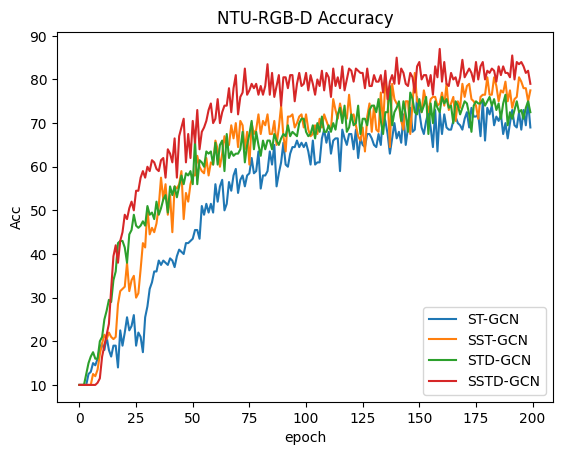

In [ ]:
x = range(200)
plt.plot(x,val_acc_list,label="ST-GCN")
plt.plot(x,val_acc_list1,label="SST-GCN")
plt.plot(x,val_acc_list2,label="STD-GCN")
plt.plot(x,val_acc_list3,label="SSTD-GCN")
plt.legend()
plt.title("NTU-RGB-D Accuracy")
plt.xlabel("epoch")
plt.ylabel("Acc")

Text(0, 0.5, 'Acc')

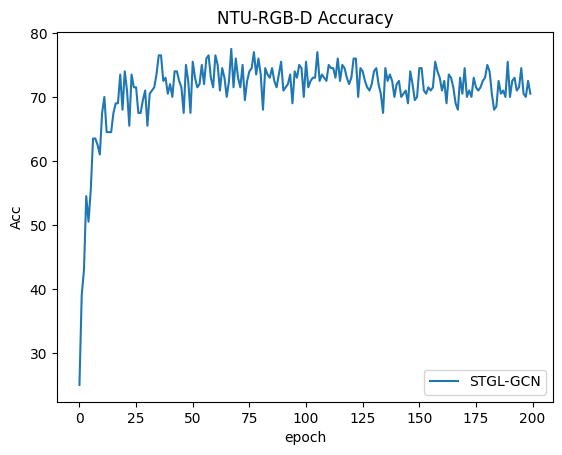

In [ ]:
"""
Supplementary Experiment 1: STGL-GCN
"""
x = range(200)
plt.plot(x,val_acc_list4,label="STGL-GCN")
plt.legend()
plt.title("NTU-RGB-D Accuracy")
plt.xlabel("epoch")
plt.ylabel("Acc")

Text(0, 0.5, 'Acc')

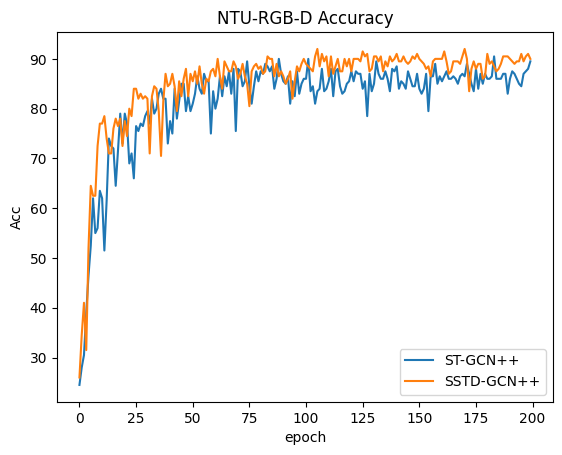

In [ ]:
"""
Supplementary Experiment 2 and 3: ST-GCN++ and SSTD-GCN++
"""
x = range(200)
plt.plot(x,val_acc_list5,label="ST-GCN++")
plt.plot(x,val_acc_list6,label="SSTD-GCN++")
plt.legend()
plt.title("NTU-RGB-D Accuracy")
plt.xlabel("epoch")
plt.ylabel("Acc")